# IMPORTING REQUIRED LIBRARIES

In [1]:
#  ! pip install openpyxl
#  ! pip install matplotlib
#  ! pip install sklearn
#  ! pip install seaborn
#  ! pip install xgboost
#  ! pip install flask

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# DATA LOADING


In [3]:
df = pd.read_excel("Village_Health_data.xlsx")

In [4]:
df

,Name,Age,Gender,Locality,Phone_No,Fever,Cough,Cold,Chest_Pain,Breathlessness,...,Ear_Pain,Eye_Irritation,Joint_Pain,Fatigue,Dizziness,Diabetes,B.P,Disease,Emergency,Hospital type
0,Person_160,0,Female,Locality_1,7252933834,0,0,0,0,0,...,0,0,0,1,0,0,0,Urology,0,Urology
1,Person_229,0,Female,Locality_1,9753374829,0,0,0,0,0,...,0,0,0,0,0,0,0,Neuro,0,Neuro Surgery
2,Person_230,0,Female,Locality_3,7189643766,0,0,0,0,0,...,0,0,0,0,0,0,0,Dental,0,Dental
3,Person_254,0,Female,Locality_5,9385920225,0,0,1,0,0,...,0,0,0,0,0,0,0,Pediatrician,0,Pediatrics
4,Person_283,0,Male,Locality_3,7177701806,1,0,0,0,0,...,0,0,0,0,0,0,0,Gastro,0,General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Person_7,90,Male,Locality_5,8888185250,0,0,0,0,0,...,0,0,0,0,0,0,0,Emergency,1,Multi-speciality
996,Person_736,90,Female,Locality_1,8925538199,1,0,0,0,0,...,0,0,0,0,0,0,0,Gastro,0,General
997,Person_811,90,Male,Locality_4,7816264387,0,0,0,0,0,...,0,1,0,1,0,1,0,Eye,0,Eye
998,Person_832,90,Male,Locality_3,8738110547,0,0,0,0,0,...,0,0,0,0,0,0,0,Gastro,0,General


# DATA EXPLORATION

In [5]:
# 1. Overview of the dataset
print("Shape of the dataset:", df.shape)
print("\nData types:\n", df.dtypes)

Shape of the dataset: (1000, 25)

Data types:
 Name              object
Age                int64
Gender            object
Locality          object
Phone_No           int64
Fever              int64
Cough              int64
Cold               int64
Chest_Pain         int64
Breathlessness     int64
Headache           int64
Stomach_Pain       int64
Vomiting           int64
Rash               int64
Tooth_Pain         int64
Ear_Pain           int64
Eye_Irritation     int64
Joint_Pain         int64
Fatigue            int64
Dizziness          int64
Diabetes           int64
B.P                int64
Disease           object
Emergency          int64
Hospital type     object
dtype: object


**Performing locality wise data exploration.**

This helps in understanding which localities of village face more diseases and related to which problem.


Locality value counts:
 Locality_5    216
Locality_1    208
Locality_2    195
Locality_3    194
Locality_4    187
Name: Locality, dtype: int64


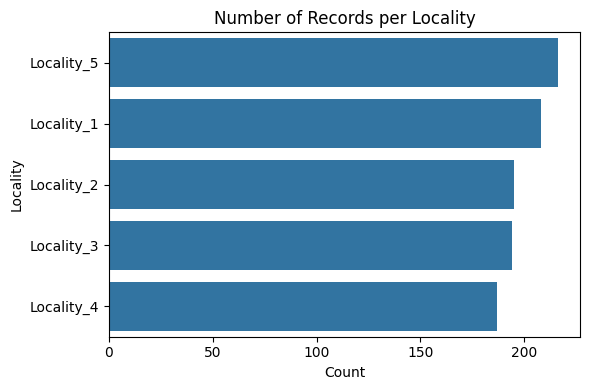

In [6]:
# Frequency distribution of Locality
locality_counts = df['Locality'].value_counts()
print("\nLocality value counts:\n", locality_counts)

# Plotting Locality distribution
plt.figure(figsize=(6,4))
sns.countplot(y='Locality', data=df, order=locality_counts.index)
plt.title('Number of Records per Locality')
plt.xlabel('Count')
plt.ylabel('Locality')
plt.tight_layout()
plt.show()

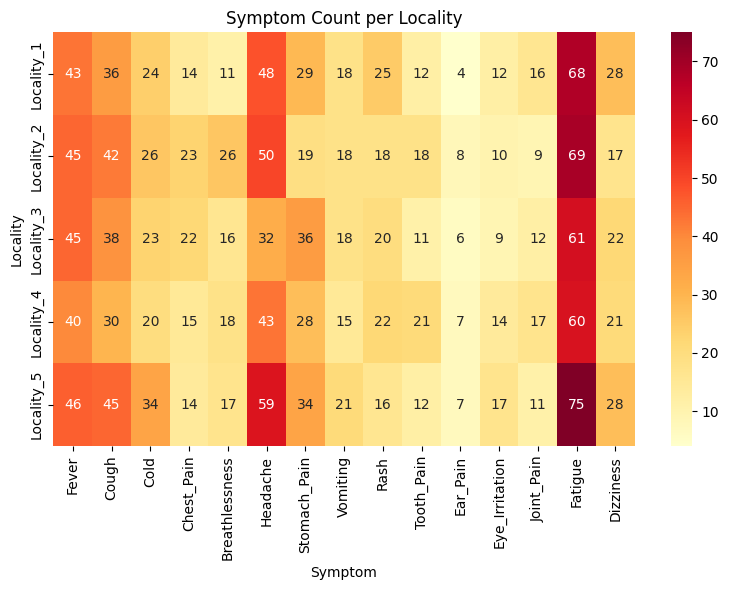

In [7]:
# Top symptoms by Locality (optional: heatmap)
symptoms = ['Fever', 'Cough', 'Cold', 'Chest_Pain', 'Breathlessness',
            'Headache', 'Stomach_Pain', 'Vomiting', 'Rash',
            'Tooth_Pain', 'Ear_Pain', 'Eye_Irritation', 'Joint_Pain',
            'Fatigue', 'Dizziness']

# Ensure symptoms are binary or 0/1
symptom_data = df.groupby('Locality')[symptoms].sum()

# Plot heatmap of symptom distribution across localities
plt.figure(figsize=(8, 6))
sns.heatmap(symptom_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Symptom Count per Locality')
plt.xlabel('Symptom')
plt.ylabel('Locality')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

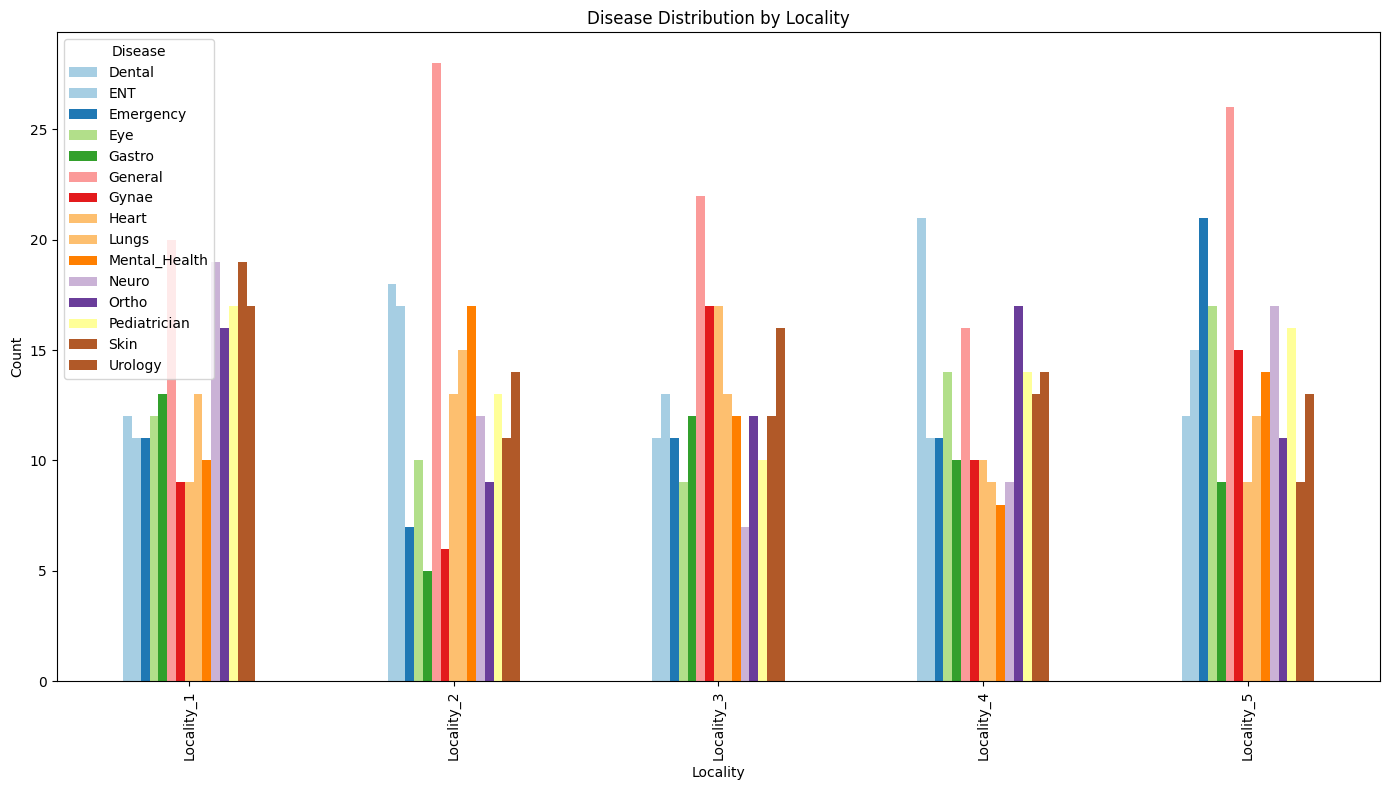

In [8]:
# 6. Disease Distribution per Locality
disease_locality = pd.crosstab(df['Locality'], df['Disease'])

plt.figure(figsize=(8,6))
disease_locality.plot(kind='bar', colormap='Paired', figsize=(14, 8))
plt.title('Disease Distribution by Locality')
plt.xlabel('Locality')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**DATA OBSERVATIONS**

The dataset is prepared based on my own observations during my survey in village "Takkellapadu".

1. Divided the village into 5 localities, and almost all localities have similar population.

2. And from the observations, it seems like almost of the localities are facing symptoms like Fatigue & Headache which might be associated with health or community level diseases.

3. Also, most of the localities are facing general, skin 7 urology related diseases.

# TRAINING AND TESTING DATASET

In [9]:
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])  # Male=1, Female=0

le_disease = LabelEncoder()
df['Disease'] = le_disease.fit_transform(df['Disease'])  # Optional: or drop

In [10]:
X = df.drop(columns=['Name', 'Locality', 'Phone_No', 'Hospital type'])  # Drop irrelevant
y = df['Hospital type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy_metrics = {}

## MODELS TRAINING

**Logistic Regression**

In [11]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

Accuracy_metrics["LogisticRegression_accuracy"] = accuracy_score(y_test, log_preds)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))
print("Classification Report:\n", classification_report(y_test, log_preds))

Logistic Regression Accuracy: 0.915
Classification Report:
                   precision    recall  f1-score   support

      Cardiology       1.00      1.00      1.00         9
          Dental       1.00      1.00      1.00         8
     Dermatology       0.93      1.00      0.97        14
             ENT       1.00      0.85      0.92        20
             Eye       0.92      1.00      0.96        12
         General       0.85      0.77      0.81        30
      Gynecology       0.77      0.77      0.77        13
       Lung Care       0.85      1.00      0.92        11
Multi-speciality       1.00      1.00      1.00        17
   Neuro Surgery       0.87      1.00      0.93        27
     Orthopedics       1.00      1.00      1.00         9
      Pediatrics       0.91      0.83      0.87        12
         Urology       0.94      0.89      0.91        18

        accuracy                           0.92       200
       macro avg       0.93      0.93      0.93       200
    weight

c:\Users\CHUND\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**KNN Classifier**

In [12]:
# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune this value

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test data
knn_preds = knn_model.predict(X_test)

Accuracy_metrics["KNN_accuracy"] = accuracy_score(y_test, knn_preds)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))
print("Classification Report:\n", classification_report(y_test, knn_preds))

KNN Accuracy: 0.72
Classification Report:
                   precision    recall  f1-score   support

      Cardiology       0.64      0.78      0.70         9
          Dental       0.62      1.00      0.76         8
     Dermatology       0.48      0.71      0.57        14
             ENT       0.65      0.55      0.59        20
             Eye       0.67      0.83      0.74        12
         General       0.80      0.93      0.86        30
      Gynecology       0.83      0.38      0.53        13
       Lung Care       0.62      0.45      0.53        11
Multi-speciality       0.62      0.47      0.53        17
   Neuro Surgery       0.86      0.89      0.87        27
     Orthopedics       0.90      1.00      0.95         9
      Pediatrics       0.67      0.50      0.57        12
         Urology       0.93      0.72      0.81        18

        accuracy                           0.72       200
       macro avg       0.71      0.71      0.69       200
    weighted avg       0.73

**Random Forest**

In [13]:
# Training the Random forest Model with this Datatset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Accuracy_metrics["RandomForest_accuracy"] = accuracy_score(y_test, y_pred_rf)

print("Random_forest Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random_forest Model Accuracy: 1.0
                  precision    recall  f1-score   support

      Cardiology       1.00      1.00      1.00         9
          Dental       1.00      1.00      1.00         8
     Dermatology       1.00      1.00      1.00        14
             ENT       1.00      1.00      1.00        20
             Eye       1.00      1.00      1.00        12
         General       1.00      1.00      1.00        30
      Gynecology       1.00      1.00      1.00        13
       Lung Care       1.00      1.00      1.00        11
Multi-speciality       1.00      1.00      1.00        17
   Neuro Surgery       1.00      1.00      1.00        27
     Orthopedics       1.00      1.00      1.00         9
      Pediatrics       1.00      1.00      1.00        12
         Urology       1.00      1.00      1.00        18

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.0

**XG_boost**

In [14]:
xgb_model = XGBClassifier(eval_metric='mlogloss')

y = le_disease.fit_transform(df['Hospital type'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

Accuracy_metrics["XG_Boost_accuracy"] = accuracy_score(y_test, xgb_preds)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

XGBoost Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        18

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



**Comparing performances of Models based on Accuracy**

In [15]:
for model,accuracy in list(Accuracy_metrics.items()):
  print(f"{model}: {accuracy*100}%")

LogisticRegression_accuracy: 91.5%
KNN_accuracy: 72.0%
RandomForest_accuracy: 100.0%
XG_Boost_accuracy: 100.0%


**Both Random forest and XGBoost are performing very well  with almost 100% accuracy.**

# Saving the Model

In [16]:
import joblib
joblib.dump(rf_model, 'hospital_prediction_model.pkl')

['hospital_prediction_model.pkl']